### Import libraries

In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
%run utils.ipynb

%matplotlib inline

Using TensorFlow backend.


#### Setting env vars

In [2]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

### Load csv

In [3]:
df = pd.read_csv('../dataset/ticket_cientista.csv', sep=';')

In [4]:
df.tail()

,attendanceType,attendanceTypeId,averageRepairTime,averageRepairTimeType,averageServiceTime,averageSolutionTime,averageWaitingTimeType,callBranch,callBranchName,callCloseDate,...,repairTimeEngineer,schedulingDate,schedulingDateTime,schedulingTime,segmentId,siteCity,siteName,siteState,slaStatus,type
43296,0,2,0,49.0,1,1,61.0,55,Florianópolis,NaN,...,0.0,NaN,NaN,NaN,14,SAO JOSE,NBB000000021722,SC,N,U
43297,0,2,0,53.0,1,1,46.0,7,Curitiba,NaN,...,0.0,NaN,NaN,NaN,14,CURITIBA,NBB000000011809,PR,N,U
43298,0,2,0,29.0,4,4,89.0,AF,Chapecó,NaN,...,0.0,NaN,NaN,NaN,14,CONCÓRDIA,NBB000000080326,SC,S,U
43299,0,2,136,42.0,55,191,43.0,2,Rio de Janeiro,20190103.0,...,136.0,2.01901e+07,"ISODate(""2019-01-03T09:44:00.000-02:00"")",09:44,14,RIO DE JANEIRO,NBB000000084973,RJ,N,U
43300,0,2,78,38.0,0,78,60.0,JJ,Barra da Tijuca,20190102.0,...,78.0,2.01901e+07,"ISODate(""2019-01-02T10:40:00.000-02:00"")",10:40,14,RIO DE JANEIRO,NBB000000013424,RJ,N,U


In [5]:
df.columns

Index(['attendanceType', 'attendanceTypeId', 'averageRepairTime',
       'averageRepairTimeType', 'averageServiceTime', 'averageSolutionTime',
       'averageWaitingTimeType', 'callBranch', 'callBranchName',
       'callCloseDate', 'callCloseTime', 'callNumber', 'callOpenDate',
       'callOpenTime', 'callRegion', 'callRegional', 'callRegionalName',
       'callRegionName', 'callStatus', 'closeDateTime', 'currentDateTime',
       'customerCode', 'deadline', 'deadlineDateTime', 'deadlineSolution',
       'engineerCode', 'equipmentType', 'onTimeSolution', 'openDateTime',
       'priority', 'productCode', 'rawCurrentDateTime', 'received_ts',
       'released_parts', 'repairTimeEngineer', 'schedulingDate',
       'schedulingDateTime', 'schedulingTime', 'segmentId', 'siteCity',
       'siteName', 'siteState', 'slaStatus', 'type'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43301 entries, 0 to 43300
Data columns (total 44 columns):
attendanceType            43301 non-null int64
attendanceTypeId          43301 non-null int64
averageRepairTime         43301 non-null int64
averageRepairTimeType     43298 non-null float64
averageServiceTime        43301 non-null int64
averageSolutionTime       43301 non-null int64
averageWaitingTimeType    43298 non-null float64
callBranch                43301 non-null object
callBranchName            43301 non-null object
callCloseDate             38856 non-null float64
callCloseTime             38856 non-null object
callNumber                43301 non-null int64
callOpenDate              43301 non-null int64
callOpenTime              43301 non-null object
callRegion                43289 non-null float64
callRegional              43301 non-null object
callRegionalName          43301 non-null object
callRegionName            32676 non-null object
callStatus                4330

## Exploratory data analysis

####  Checking missing data

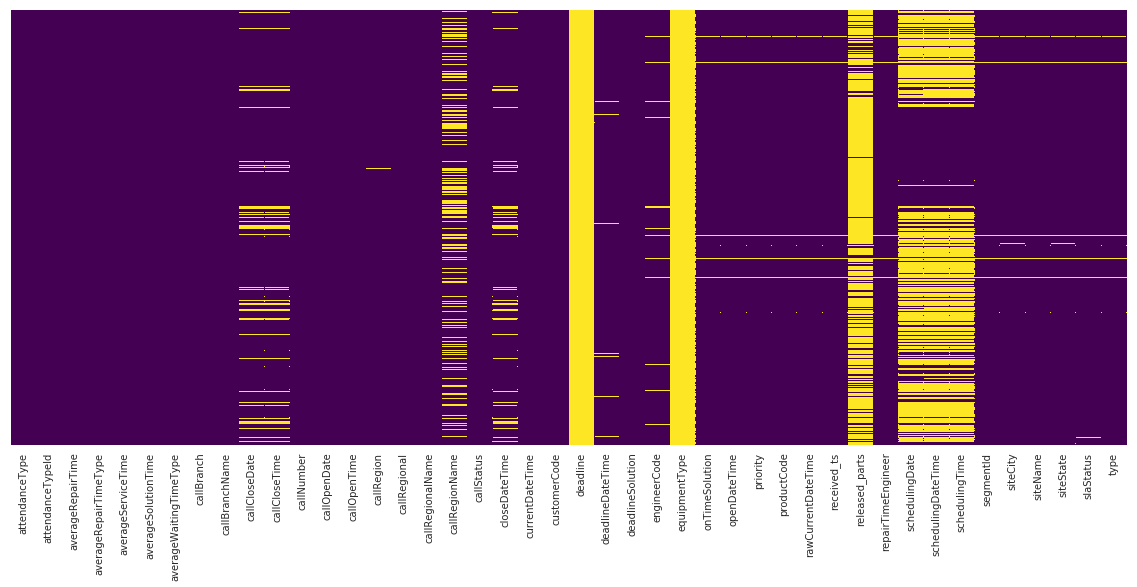

In [7]:
plt.figure(figsize=(20,8)) 
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

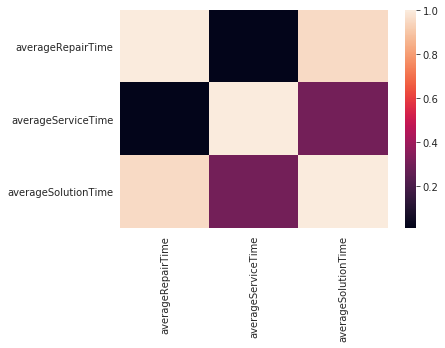

In [8]:
sns.heatmap(df[['averageRepairTime', 'averageServiceTime', 'averageSolutionTime']].corr())

##### To Do

Infer some information of the rest of data, if I have time:
    - columns relationships
    - replace nan values
    - fix wrong values (e.g. states)
    - normalize strings (e.g. names of cities)
    - ...

### Selecting relevant information for problem

In [9]:
df_relevant = df[['currentDateTime', 'customerCode', 'onTimeSolution', 'callStatus', 'callOpenDate', 'deadlineDateTime', 'siteState']]
df_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43301 entries, 0 to 43300
Data columns (total 7 columns):
currentDateTime     43301 non-null object
customerCode        43301 non-null int64
onTimeSolution      42900 non-null object
callStatus          43301 non-null object
callOpenDate        43301 non-null int64
deadlineDateTime    42637 non-null object
siteState           42833 non-null object
dtypes: int64(2), object(5)
memory usage: 2.3+ MB


#### Treating date/time

In [10]:
"""During the treatment of the dates I realized that there were two dates of 1970 differing from the others. 
So, I builded this function using deadlineDateTime column to solve this problem. """ 

def fix_old_dates(row):
    if '1970' in row['currentDateTime']:
        return row['deadlineDateTime']
    else: 
        return row['currentDateTime']

In [11]:
df_relevant.currentDateTime = df_relevant.apply(fix_old_dates, axis=1)
df_relevant.currentDateTime = pd.to_datetime(df_relevant.currentDateTime.apply(transform_iso_in_datetime))
df_relevant.deadlineDateTime = pd.to_datetime(df_relevant.deadlineDateTime.apply(transform_iso_in_datetime))
df_relevant.sort_values('currentDateTime', inplace=True)
df_relevant.head()

,currentDateTime,customerCode,onTimeSolution,callStatus,callOpenDate,deadlineDateTime,siteState
15847,2017-11-10 01:59:00,8068,S,CC,20171024,2017-11-10 01:59:00,PE
15845,2017-11-14 21:44:02,8068,S,DV,20171003,2017-10-20 01:59:00,MT
15846,2017-11-17 01:59:00,8068,S,CC,20171030,2017-11-17 01:59:00,PR
9812,2018-01-08 13:03:33,3363,S,AT,20180105,2018-01-11 14:03:00,DF
9808,2018-01-08 21:15:42,3363,S,PR,20180103,2018-01-11 18:48:00,SP


#### Observing number of calls

In [12]:
df_relevant.onTimeSolution.unique()

array(['S', 'N', nan, 'ISODate("2019-01-02T12:01:00.000-02:00")',
       'ISODate("2019-01-04T11:24:00.000-02:00")',
       'ISODate("2019-01-14T08:27:00.000-02:00")',
       'ISODate("2018-11-01T09:33:00.000-03:00")',
       'ISODate("2019-01-21T14:44:00.000-02:00")',
       'ISODate("2019-01-21T14:24:00.000-02:00")',
       'ISODate("2019-01-29T10:19:00.000-02:00")',
       'ISODate("2019-01-30T16:07:00.000-02:00")',
       'ISODate("2019-02-11T12:04:00.000-02:00")',
       'ISODate("2019-02-11T09:11:00.000-02:00")',
       'ISODate("2019-02-19T14:18:00.000-03:00")',
       'ISODate("2019-02-21T10:30:00.000-03:00")',
       'ISODate("2019-02-21T15:27:00.000-03:00")',
       'ISODate("2019-02-25T12:46:00.000-03:00")'], dtype=object)

Original problem:
- "Para identificar qual  ticket ja foi fechado , usa-se a coluna “callStatus”, onde os status fechados são: N0, N4 e CV."
- "Para identificar quais tickets foram fechados dentro ou fora do SLA , usa-se a coluna “onTimeSolution”(S = foi fechado dentro e N = não foi fechado dentro)"

In [13]:
def replace_on_time_solution_values(row):
    if row['onTimeSolution'] not in ['S', 'N']:
        if row['callStatus'] in ['N0', 'N4', 'CV']:
            if row['currentDateTime'] > row['deadlineDateTime']:
                return 'N'
            else:
                # when deadlineDateTime is NaT the case is included here
                return 'S'
        else:
            return 'N'
    return row['onTimeSolution']

In [14]:
df_relevant['onTimeSolution'] = df_relevant.apply(replace_on_time_solution_values, axis=1)
# df_relevant.onTimeSolution.unique()

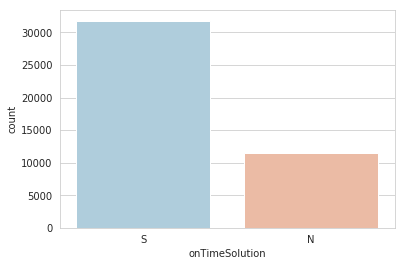

In [15]:
sns.countplot(x='onTimeSolution',data=df_relevant,palette='RdBu_r')

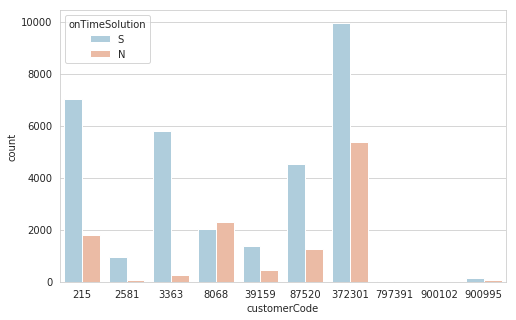

In [16]:
plt.figure(figsize=(8,5)) 
sns.countplot(x='customerCode',hue='onTimeSolution',data=df_relevant,palette='RdBu_r')

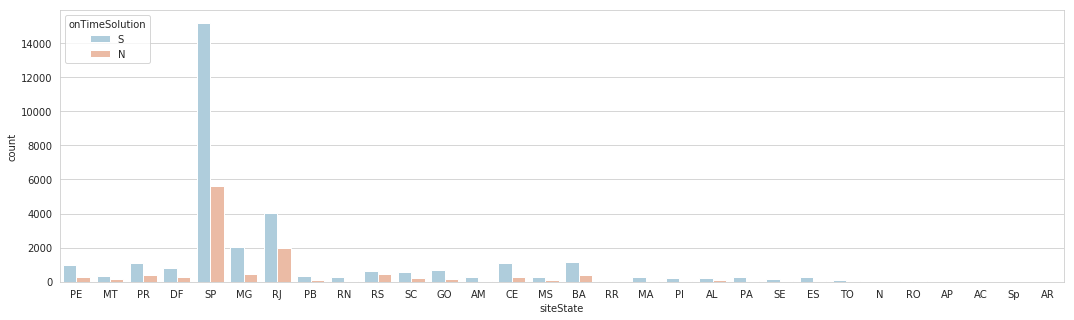

In [17]:
plt.figure(figsize=(18,5)) 
sns.countplot(x='siteState',hue='onTimeSolution',data=df_relevant,palette='RdBu_r')

#### Observing number of customers and filtering relevant dates

- "01 de Janeiro de 2019 até 26 de Fevereiro de 2019"

Number of customers: 10 | SLA options: ['S' 'N']


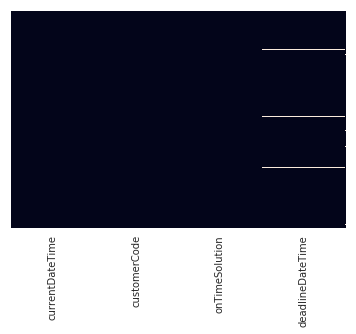

In [18]:
# From now on I will select only the relevant information for the problem.
df_relevant = df_relevant[['currentDateTime', 'customerCode', 'onTimeSolution', 'deadlineDateTime']]
print("Number of customers: {} | SLA options: {}".format(df_relevant.customerCode.nunique(), df_relevant.onTimeSolution.unique()))
sns.heatmap(df_relevant.isnull(),yticklabels=False,cbar=False)

In [19]:
years = [dt.year for dt in df_relevant.currentDateTime]
np.unique(years)

array([2017, 2018, 2019])

In [20]:
df_relevant.currentDateTime = [dt.date() for dt in df_relevant.currentDateTime]
df_relevant.currentDateTime = pd.to_datetime(df_relevant.currentDateTime)
df_relevant.rename(columns={'currentDateTime': 'currentDate'}, inplace=True)
df_relevant.head(10)

,currentDate,customerCode,onTimeSolution,deadlineDateTime
15847,2017-11-10,8068,S,2017-11-10 01:59:00
15845,2017-11-14,8068,S,2017-10-20 01:59:00
15846,2017-11-17,8068,S,2017-11-17 01:59:00
9812,2018-01-08,3363,S,2018-01-11 14:03:00
9808,2018-01-08,3363,S,2018-01-11 18:48:00
9807,2018-01-08,3363,S,2018-01-11 19:34:00
9805,2018-01-08,3363,S,2018-01-11 18:33:00
15128,2018-01-08,3363,S,2018-01-01 14:07:00
9810,2018-01-08,3363,S,2018-01-11 18:58:00
9809,2018-01-08,3363,S,2018-01-11 19:18:00


#### Write in a new file

In [21]:
df_relevant.to_csv('../dataset/ticket_cientista_pre_processed.csv', index=False)